In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"           
import scipy.io as sio
import sys                                                                              
import h5py as hp
import argparse
import random           
import numpy as np
import cv2
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift,ifftshift

from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import convolve2d, correlate2d
from scipy.optimize import curve_fit
import scipy 

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))#x/np.amax(x)#
def normalize_t(x):
    return (x-torch.amin(x))/(torch.amax(x)-torch.amin(x))#x/np.amax(x)#


def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d
def autocor2d_t(I):
#     f = torch.absolute(torch.fft.fft2(I))**2

#     autocor2d = torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2))/I.shape[0]/I.shape[1]
    return  torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2),dim=(-2,-1))/I.shape[-1]/I.shape[-2]

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)
#load exp data

filename = [#one interval
#             "../expdata/mesh_1_220710/220710_153Z_MCC_less45_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153S_KCl_below106_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153L_KCl_106-180_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153A_KCl_180-250_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153B_KCl_250-300_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153D_KCl_355-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153E_KCl_425-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153I_KCl_above500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #two interval
            "expdata/mesh_1_220710/220710_153P_KCl_106-250_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153K_KCl_180-300_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153F_KCl_250-355_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153G_KCl_300-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153M_KCl_355-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #three interval
            "expdata/mesh_1_220710/220710_153N_KCl_180-355_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153T_KCl_250-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153R_KCl_355-1000_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #four interval
            "expdata/mesh_1_220710/220710_153Q_KCl_180-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153O_KCl_250-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #five interval
            "expdata/mesh_1_220710/220710_153H_KCl_180-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",    
            ]
basefilename =  "expdata/mesh_1_220710/220710_153Z_MCC_less45_500frame_200us_0ms_180GAN_bin2.npz_auto.npz"
basename = '<45 um'            
name = [#one interval
#         '<45 μm',
        '0-106 um',
        '106-180 um',
        '180-250 um',
        '250-300 um',
#         '300-355 μm',
        '355-425 um',
        '425-500 um',
        '500-1000 um',
        #two interval
        '106-250 um',
        '180-300 um',
        '250-355 um',
        '300-425 um',
        '355-500 um',
        #three interval
        '180-355 um',
        '250-425 um',
        '355-1000 um',
        #four interval
        '180-425 um',
        '250-500 um',
        #five interval
        '180-500 um']

# 

In [2]:
data_exp = np.load('expdata/Pupil_18curves_PSD_cumul_auto1frame-fine powder base_betaD.npz')
PSD_exp = data_exp["PSD_exp"] # PSD of the measured data
cumul_exp = data_exp['cumul_exp'] #cumul of the measured data
auto_exp = np.abs(data_exp['auto_exp'].reshape((18,50,1,96,96)))**0.25 #measured 200 frames average-autocorrelation

data_sim = np.load('expdata/Pupil_simulation_PSD_cumul_auto10frame-fine powder base_lognormal.npz')
auto_sim = np.abs(data_sim['auto_sim'].reshape((9000,1,96,96)))**0.25 #calculation from the synthetic data 
PSD_sim = data_sim["PSD_sim"] # PSD of the synthetic data
cumul_sim = data_sim['cumul_sim'] #cumul of the synthetic data
auto_expgen = np.abs(data_sim['auto_expgen'].reshape((18,50,1,96,96)))**0.25 #calculation from the measured PSD


print("PSD_sim ",PSD_sim.shape)
print("cumul_sim ",cumul_sim.shape)
print("auto_sim ",auto_sim.shape)
print("auto_expgen ",auto_expgen.shape)
print("PSD_exp ",PSD_exp.shape)
print("cumul_exp ",cumul_exp.shape)
print("auto_exp ",auto_exp.shape)


PSD_sim  (9000, 192)
cumul_sim  (9000, 192)
auto_sim  (9000, 1, 96, 96)
auto_expgen  (18, 50, 1, 96, 96)
PSD_exp  (18, 50, 192)
cumul_exp  (18, 50, 192)
auto_exp  (18, 50, 1, 96, 96)


603.0


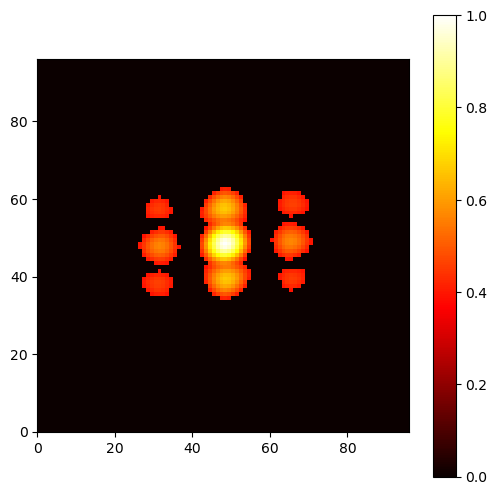

In [5]:

idx =0

mask = np.zeros(auto_exp[idx,0,0].shape)
mask[auto_exp[idx,0,0]>0.39] = 1

mask_t = torch.tensor(mask,dtype=torch.float).cuda()


#plot the 200 avraged autocorrelation
plt.figure(figsize=(6,6))
plt.pcolormesh((auto_exp[idx,0,0]) *mask ,cmap=plt.cm.hot,
              label = name[1])
plt.colorbar()
# plt.clim(0.,1.)
plt.gca().set_aspect('equal')
print(np.sum(mask))



In [ ]:
# np.savez("expdata/mask_for_learning.npz",mask=mask)

In [6]:
class residual_block(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=1,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(residual_block, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.stride_1 = stride_1 #the first block stride, 1 for normal, 2 for downsampling
        self.stride_2 = stride_2 #the second block stride, 1 for normal, 2 for downsampling
        self.dilation = dilation
        self.pad_1 = (2+dilation[0]*(kernel_size[0]-1)-stride_1)//2
        self.pad_2 = (2+dilation[0]*(kernel_size[0]-1)-stride_2)//2
        if activation=='leaky_relu':
            self.a = nn.LeakyReLU()#F.leaky_relu()
        elif activation=='relu':
            self.a = nn.ReLU()#F.relu()
        elif activation=='sigmoid':
            self.a = nn.Sigmoid()
        elif activation=='tanh':
            self.a = nn.Tanh()
        
#         self.bn1 = nn.BatchNorm2d(self.in_filters)
#         self.bn2 = nn.BatchNorm2d(self.out_filters)
        
        self.bn1 = nn.InstanceNorm2d(self.in_filters)
        self.bn2 = nn.InstanceNorm2d(self.out_filters)
        self.conv1 = nn.Conv2d(self.in_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_1, dilation=self.dilation,padding=self.pad_1)
        
        self.conv2 = nn.Conv2d(self.out_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_2, dilation=self.dilation,padding=self.pad_2)
        
        self.conv3 = nn.Conv2d(self.in_filters,self.out_filters, kernel_size=(1,1), padding=0,
                               stride=self.stride_1,dilation=(1,1))

    def forward(self, x):
        res = self.bn1(x)
        res = self.a(res)
        shortcut = self.conv3(res)
        res = self.conv1(res)
        res = self.bn2(res)
        res = self.a(res)
        res = self.conv2(res)
        res = res+shortcut
        
        return res
    
class down_residual_layer(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(down_residual_layer, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation=self.activation)

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation=self.activation)
        
        self.dropout = nn.Dropout(0.02)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output


class Generator(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(Generator, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation='relu')

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation='leaky_relu')
        
        self.dropout = nn.Dropout(0.02)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output
                    
                   
class Predictor(nn.Module):
    def __init__(self, fd):
        super(Predictor, self).__init__()
        self.filters = fd
#         self.down_residual_layer_1 = down_residual_layer(self.filters[0],self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
#         self.residual_block_2 = residual_block(self.filters[1],self.filters[1], kernel_size=(3,3), 
#                                                stride_1=1,stride_2=1,dilation=(1,1), activation='leaky_relu')
        
#         self.dropout1 = nn.Dropout(0.05)
        self.down_residual_layer_2 = down_residual_layer(self.filters[1],self.filters[2], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)  
        self.down_residual_layer_3 = down_residual_layer(self.filters[2],self.filters[3], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1) 
        self.down_residual_layer_4 = down_residual_layer(self.filters[3],self.filters[4], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
#         self.down_residual_layer_5 = down_residual_layer(self.filters[4],self.filters[5], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    

        self.bn = nn.InstanceNorm2d(self.filters[4])
#         self.bn = nn.InstanceNorm2d(self.filters[5])

        self.dropout = nn.Dropout(0.02)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(6*6*self.filters[4], 192)   

    def forward(self, x):
#         x = self.residual_block_2(x)
#         x = self.dropout1(x)
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        x = self.down_residual_layer_4(x)
#         x = self.down_residual_layer_5(x)
        x = self.bn(x)
        x = F.leaky_relu(x,negative_slope=0.1)
        x = self.flatten(x)
        x = self.linear1(x)
        output = torch.sigmoid(x)
        return output

#     def first_stage_output(self,x):
#         output = self.down_residual_layer_1(x)
#         return output
    
    def second_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        output = self.down_residual_layer_2(x)
        return output
    
    def third_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        output = self.down_residual_layer_3(x)
        return output
    
    def fourth_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        output = self.down_residual_layer_4(x)
        return output

In [8]:


model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_generator_1.pt'
generator = torch.load(model_path)
generator.eval()
generator.cuda()
model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_predictor_1.pt'
predictor = torch.load(model_path)
predictor.eval()
predictor.cuda()

Predictor(
  (down_residual_layer_2): down_residual_layer(
    (residual_block_1): residual_block(
      (a): LeakyReLU(negative_slope=0.01)
      (bn1): InstanceNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(12, 16, kernel_size=(1, 1), stride=(2, 2))
    )
    (residual_block_2): residual_block(
      (a): LeakyReLU(negative_slope=0.01)
      (bn1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), paddin

In [9]:
predictor.eval()
generator.eval()
fileidx = 16
auto_expgen_t = torch.tensor(auto_expgen, dtype=torch.float).cuda()
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()
cumul_exp_t = torch.tensor(cumul_exp).to('cuda')
mask_t = torch.tensor(mask,dtype=torch.float).cuda()


auto_predict_expgen_plot = np.zeros((18,96,96))
#average reduce the cumul predict to 64
cumul_predict_plot_r = np.zeros((18,192//3))
cumul_predict_plot = np.zeros((18,192))

pred_PSD = np.zeros((18,cumul_predict_plot_r.shape[-1]-1))
pred_PSD_d = np.zeros((18,cumul_predict_plot.shape[-1]-1))
for i in tqdm(range(18)):
    #predict generalized auto_expgen
#     auto_predict_expgen_plot[i] = generator(auto_expgen_t[i,0:1]).reshape((96,96)).cpu().detach().numpy()
#     auto_predict_expgen_plot[i] = (auto_predict_expgen_plot[i]) 

    cumul_predict_plot[i] = predictor(generator(auto_exp_t[i,1:2]*mask_t)).reshape(192).cpu().detach().numpy()
    cumul_predict_plot[i] = normalize(cumul_predict_plot[i])#

    cumul_predict_plot_r[i] = rebin1d(cumul_predict_plot[i],(64))
    pred_PSD[i] = -(cumul_predict_plot_r[i] - np.roll(cumul_predict_plot_r[i],1))[1:64]
    pred_PSD[i] = pred_PSD[i]/np.sum(pred_PSD[i])/3
    pred_PSD[i,pred_PSD[i]<0]=0
    
    pred_PSD_d[i] = -(cumul_predict_plot[i] - np.roll(cumul_predict_plot[i],1))[1:192]
    pred_PSD_d[i] = pred_PSD_d[i]/np.sum(pred_PSD_d[i])/3
    pred_PSD_d[i,pred_PSD_d[i]<0]=0
    
    
x_new_r = np.linspace(10, 1200, num=64, endpoint=True)
x_new = np.linspace(10, 1200, num=192, endpoint=True)
idx = np.array([0,2,4,6,8,10,12,14,17,
               1,3,5,7,9,11,13,15,16])
    

  0%|          | 0/18 [00:00<?, ?it/s]

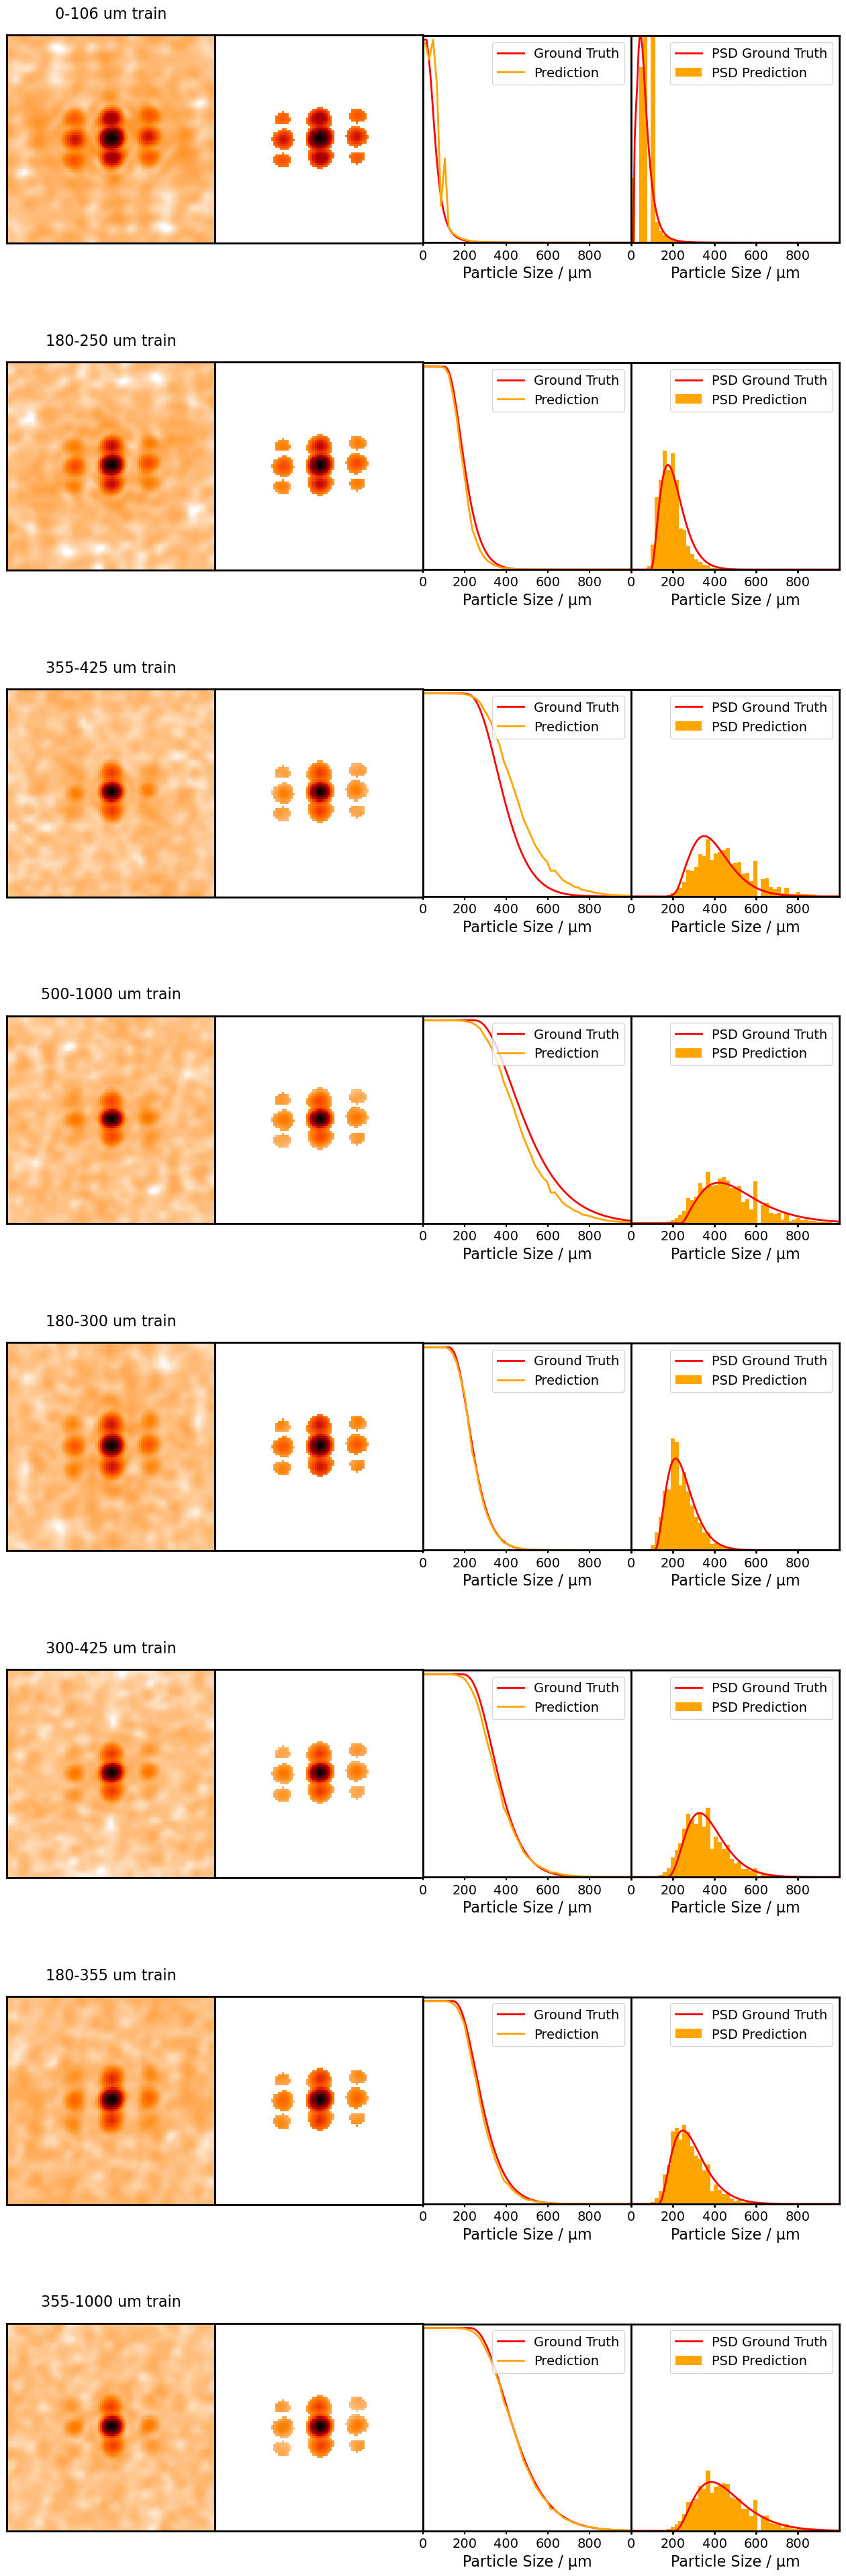

In [16]:

fig, axs = plt.subplots(8,4, figsize=(4*4, 5*10), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.001)

for j in range(8):
    i = int(idx[j])
    axs[j,0].pcolormesh(((auto_exp[i,0].reshape((96,96)))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,0].set_aspect('equal')

    axs[j,0].set_title(name[i] +" train", y=1, pad=18 ,color='k',fontsize=16)
   
    axs[j,0].set_xticks([])
    axs[j,0].set_yticks([])
    [x.set_linewidth(2) for x in axs[j,0].spines.values()]
    
#     axs[j,1].pcolormesh((auto_predict_expgen_plot[i].reshape((96,96))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
#     axs[j,1].set_aspect('equal')
#     axs[j,1].set_yticks([])
#     axs[j,1].set_xticks([])
#     [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,1].pcolormesh(((auto_exp[i,0].reshape((96,96))))*mask,vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,1].set_aspect('equal')
    axs[j,1].set_yticks([])
    axs[j,1].set_xticks([])
    [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,2].plot(x_new,cumul_exp[i,0],'r-',linewidth=2, label='Ground Truth')
    axs[j,2].plot(x_new_r, cumul_predict_plot_r[i],color='orange',linewidth=2, label='Prediction')
    axs[j,2].legend(prop={'size': 14},loc="upper right")
    axs[j,2].set_aspect(995/1.02)
    axs[j,2].set_xlim(0,1000)
    axs[j,2].set_ylim(0.,1.02)
    axs[j,2].set_yticks([])
    axs[j,2].set_xticks([0,200,400,600,800])
    axs[j,2].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,2].xaxis.set_tick_params(labelsize=14,width=1.5)
    [x.set_linewidth(2) for x in axs[j,2].spines.values()]

    axs[j,3].bar(x_new_r[0:-1], pred_PSD[i], width=20, fill=True, 
                 color='orange',label='PSD Prediction')
    axs[j,3].plot(x_new, PSD_exp[i,0],color='r',linewidth=2,label='PSD Ground Truth')
    axs[j,3].legend(prop={'size': 14},loc="upper right")
    axs[j,3].set_xlim(0,1000)
    axs[j,3].set_ylim(0,0.09)
    axs[j,3].set_yticks([])
    axs[j,3].set_xticks([0,200,400,600,800])
    axs[j,3].xaxis.set_tick_params(labelsize=14,width=2)
    axs[j,3].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,3].set_aspect(995/0.09)
    [x.set_linewidth(2) for x in axs[j,3].spines.values()]

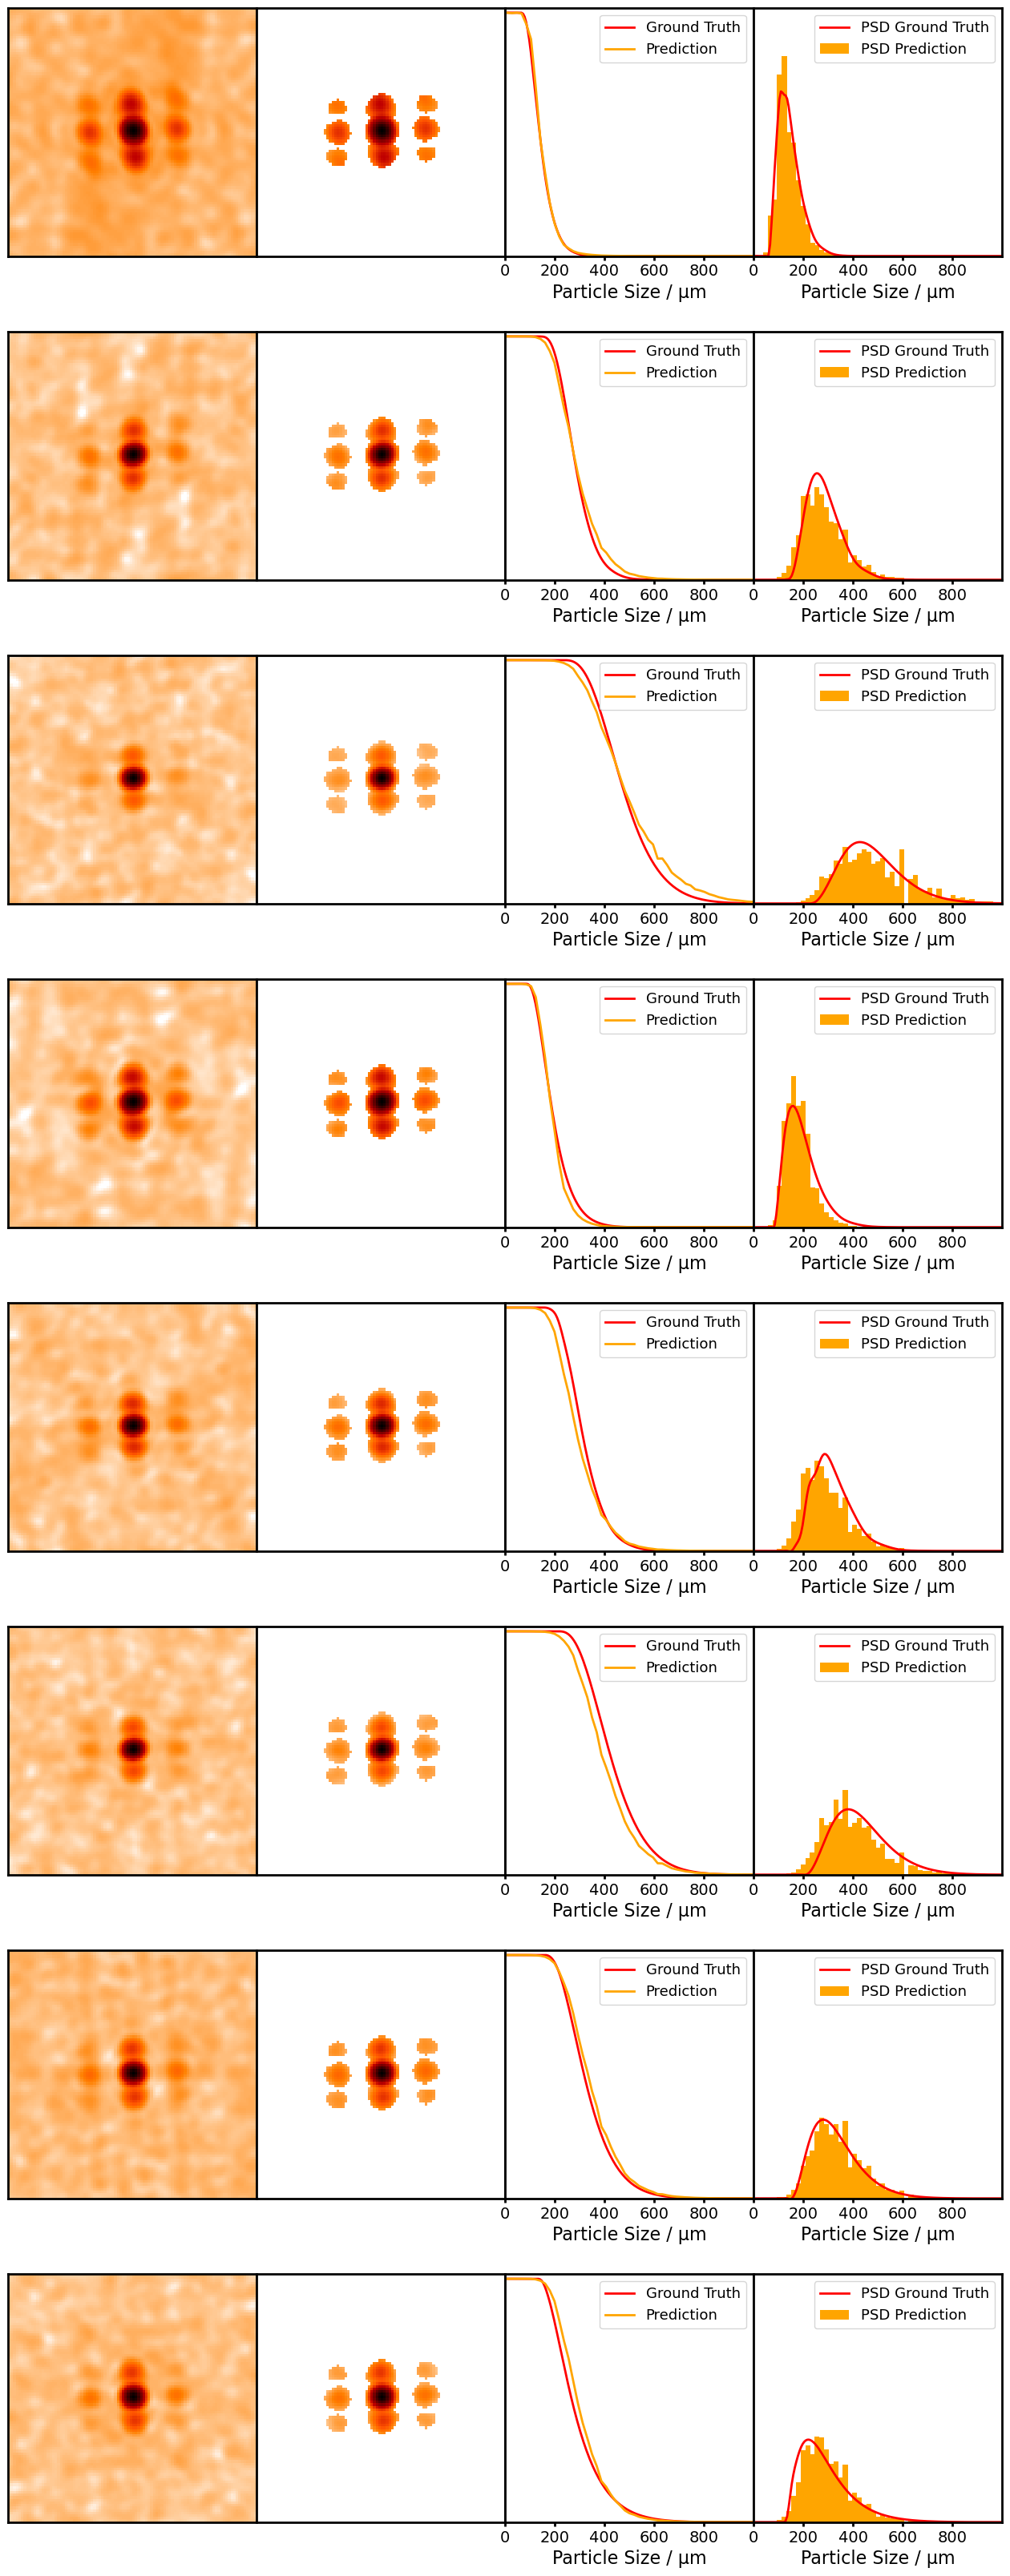

In [21]:

fig, axs = plt.subplots(8,4, figsize=(4*4, 5*8.3), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.001)

for j in range(8):
    i = int(idx[j+9])
    axs[j,0].pcolormesh(((auto_exp[i,0].reshape((96,96)))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,0].set_aspect('equal')

#     axs[j,0].set_title(name[i]+' test', y=1, pad=18 ,color='k',fontsize=16)

    axs[j,0].set_xticks([])
    axs[j,0].set_yticks([])
    [x.set_linewidth(2) for x in axs[j,0].spines.values()]
    
#     axs[j,1].pcolormesh((auto_predict_expgen_plot[i].reshape((96,96))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
#     axs[j,1].set_aspect('equal')
#     axs[j,1].set_yticks([])
#     axs[j,1].set_xticks([])
#     [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,1].pcolormesh(((auto_exp[i,0].reshape((96,96))))*mask,vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,1].set_aspect('equal')
    axs[j,1].set_yticks([])
    axs[j,1].set_xticks([])
    [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,2].plot(x_new,cumul_exp[i,0],'r-',linewidth=2, label='Ground Truth')
    axs[j,2].plot(x_new_r, cumul_predict_plot_r[i],color='orange',linewidth=2, label='Prediction')
    axs[j,2].legend(prop={'size': 13},loc="upper right")
    axs[j,2].set_aspect(1000/1.02)
    axs[j,2].set_xlim(0,1000)
    axs[j,2].set_ylim(0.,1.02)
    axs[j,2].set_yticks([])
    axs[j,2].set_xticks([0,200,400,600,800])
    axs[j,2].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,2].xaxis.set_tick_params(labelsize=14,width=2)
    [x.set_linewidth(2) for x in axs[j,2].spines.values()]

    axs[j,3].bar(x_new_r[0:-1], pred_PSD[i], width=20, fill=True, 
                 color='orange',label='PSD Prediction')
    axs[j,3].plot(x_new, PSD_exp[i,0],color='r',linewidth=2,label='PSD Ground Truth')
    axs[j,3].legend(prop={'size': 13},loc="upper right")
    axs[j,3].set_xlim(0,1000)
    axs[j,3].set_ylim(0,0.09)
    axs[j,3].set_yticks([])
    axs[j,3].set_xticks([0,200,400,600,800])
    axs[j,3].xaxis.set_tick_params(labelsize=14,width=2)
    axs[j,3].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,3].set_aspect(1000/0.09)
    [x.set_linewidth(2) for x in axs[j,3].spines.values()]
    
    
fig.savefig('figures/fig_3c.pdf', dpi='figure', format=None)

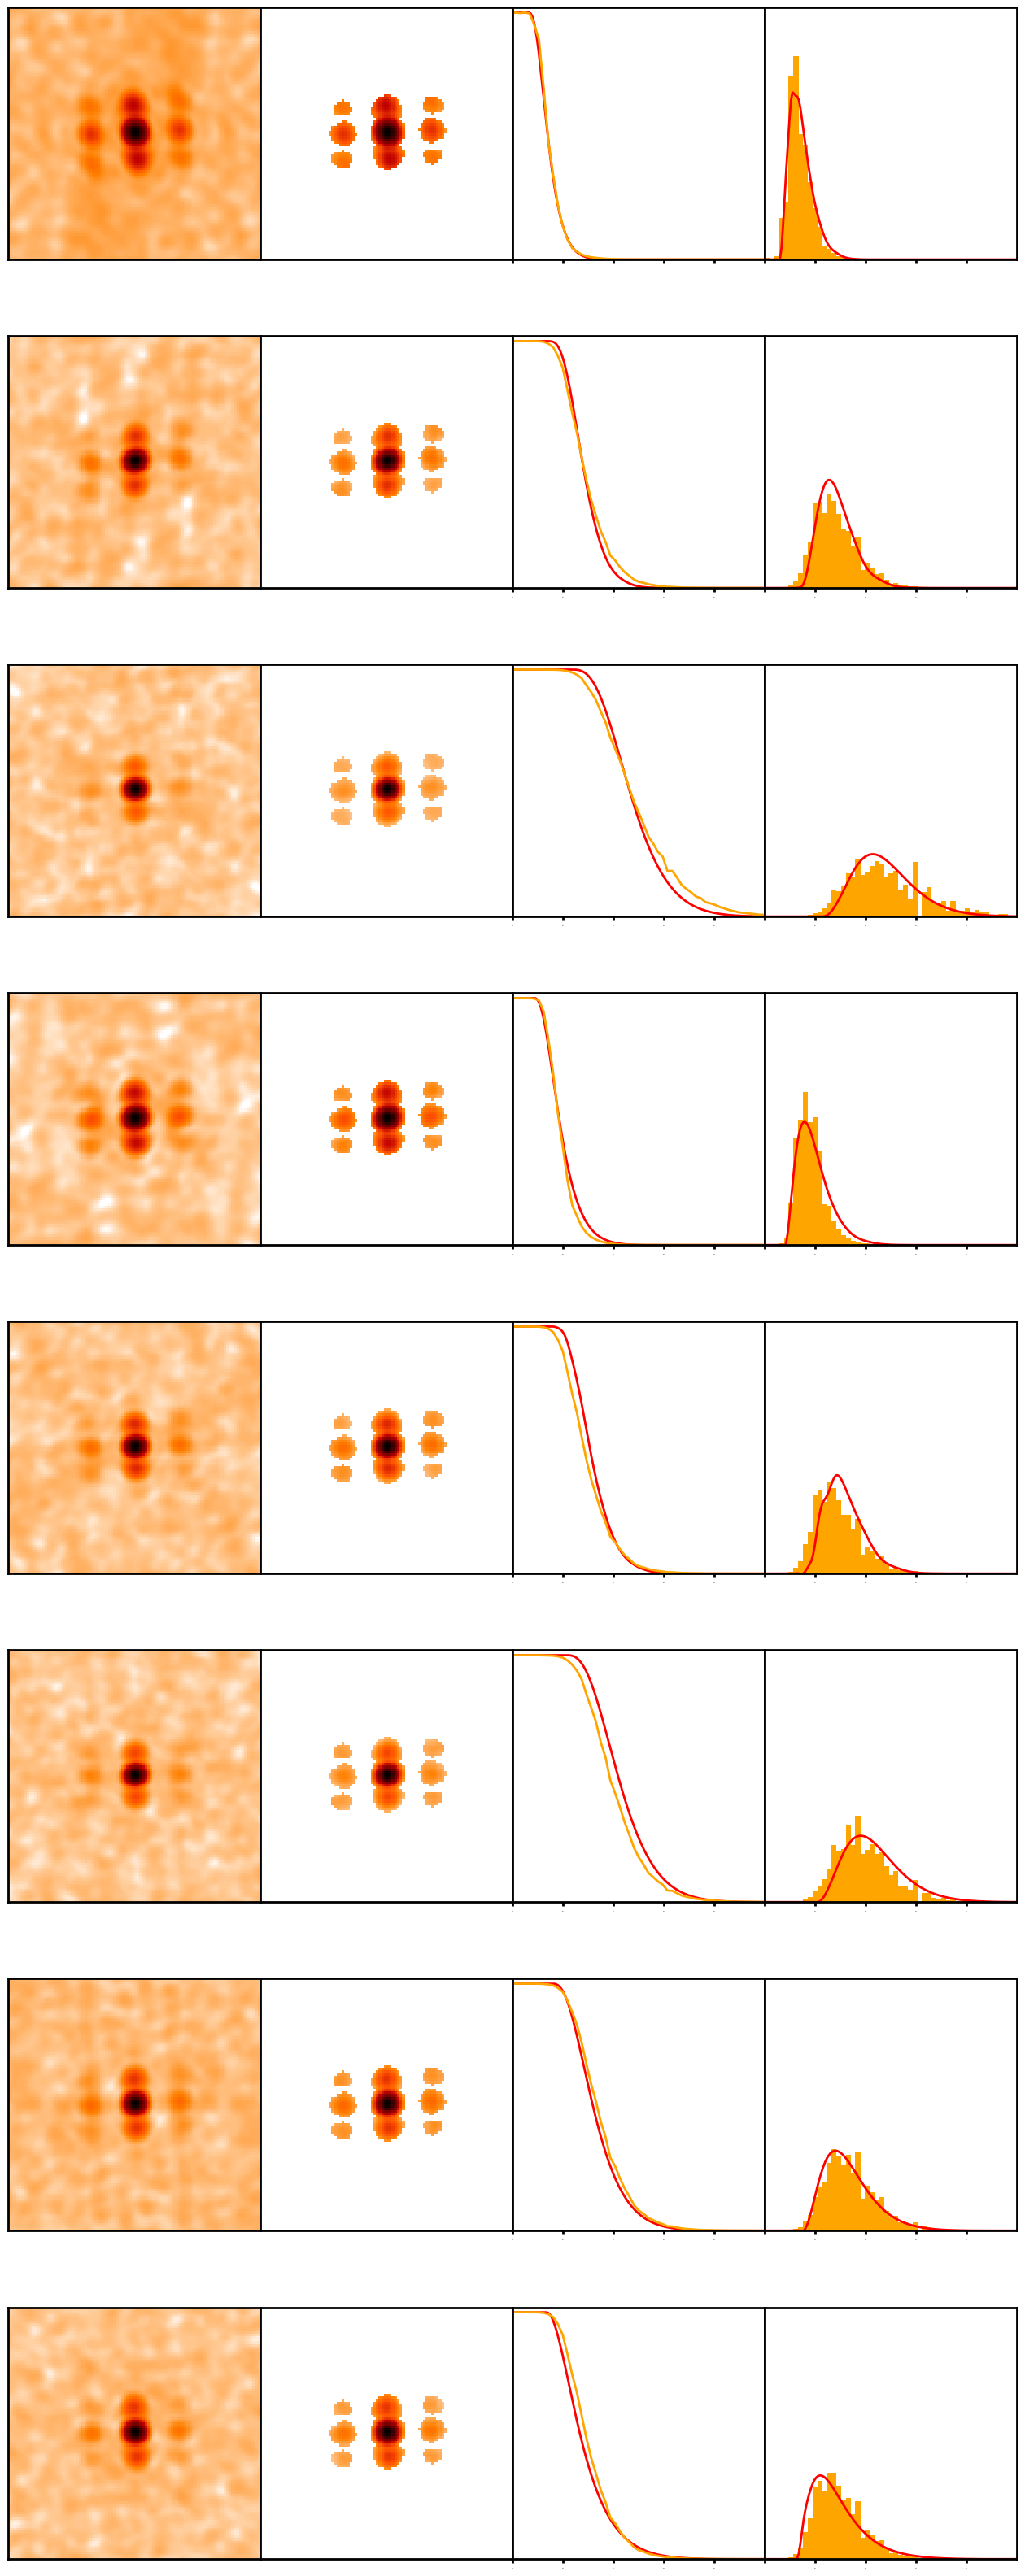

In [24]:

fig, axs = plt.subplots(8,4, figsize=(4*4, 5*8.3), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.001)

for j in range(8):
    i = int(idx[j+9])
    axs[j,0].pcolormesh(((auto_exp[i,0].reshape((96,96)))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,0].set_aspect('equal')

#     axs[j,0].set_title(name[i]+' test', y=1, pad=18 ,color='k',fontsize=16)

    axs[j,0].set_xticks([])
    axs[j,0].set_yticks([])
    [x.set_linewidth(2) for x in axs[j,0].spines.values()]
    
#     axs[j,1].pcolormesh((auto_predict_expgen_plot[i].reshape((96,96))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
#     axs[j,1].set_aspect('equal')
#     axs[j,1].set_yticks([])
#     axs[j,1].set_xticks([])
#     [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,1].pcolormesh(((auto_exp[i,0].reshape((96,96))))*mask,vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,1].set_aspect('equal')
    axs[j,1].set_yticks([])
    axs[j,1].set_xticks([])
    [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,2].plot(x_new,cumul_exp[i,0],'r-',linewidth=2, label='Ground Truth')
    axs[j,2].plot(x_new_r, cumul_predict_plot_r[i],color='orange',linewidth=2, label='Prediction')
#     axs[j,2].legend(prop={'size': 13},loc="upper right")
    axs[j,2].set_aspect(1000/1.02)
    axs[j,2].set_xlim(0,1000)
    axs[j,2].set_ylim(0.,1.02)
    axs[j,2].set_yticks([])
    axs[j,2].set_xticks([0,200,400,600,800])
#     axs[j,2].set_xlabel('Particle Size / μm',fontsize=0)
    axs[j,2].xaxis.set_tick_params(labelsize=0,width=2)
    [x.set_linewidth(2) for x in axs[j,2].spines.values()]

    axs[j,3].bar(x_new_r[0:-1], pred_PSD[i], width=20, fill=True, 
                 color='orange',label='PSD Prediction')
    axs[j,3].plot(x_new, PSD_exp[i,0],color='r',linewidth=2,label='PSD Ground Truth')
#     axs[j,3].legend(prop={'size': 13},loc="upper right")
    axs[j,3].set_xlim(0,1000)
    axs[j,3].set_ylim(0,0.09)
    axs[j,3].set_yticks([])
    axs[j,3].set_xticks([0,200,400,600,800])
    axs[j,3].xaxis.set_tick_params(labelsize=0.000,width=2)
#     axs[j,3].set_xlabel('Particle Size / μm',fontsize=0.000)
    axs[j,3].set_aspect(1000/0.09)
    [x.set_linewidth(2) for x in axs[j,3].spines.values()]
    
    
fig.savefig('figures/fig_3c_2.tiff', dpi=350, format=None)